## Matrix Factorization

- MovieLens 데이터셋 활용하기
- SVD를 직접 구현하고, 적절한 k값 찾기
- matrix factorization을 간단히 할 수 있는 파이썬 라이브러리 소개

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pandas as pd
import numpy as np
from math import sqrt
from tqdm import tqdm_notebook as tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

#Dataset 불러오기

In [ ]:
path = '/content/drive/MyDrive/data/movielens'
ratings_df = pd.read_csv(os.path.join(path, 'ratings.csv'), encoding='utf-8')

print(ratings_df.shape)
print(ratings_df.head())

(100836, 4)
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931


In [ ]:
train_df, test_df = train_test_split(ratings_df, test_size=0.2, random_state=1234)

print(train_df.shape)
print(test_df.shape)

(80668, 4)
(20168, 4)


#Sparse Matrix 만들기

In [ ]:
sparse_matrix = train_df.groupby('movieId').apply(lambda x: pd.Series(x['rating'].values, index=x['userId'])).unstack()
sparse_matrix.index.name = 'movieId'

sparse_matrix

userId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,4.0,NaN,4.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.5,NaN,NaN,3.5,4.0,NaN,3.5,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,3.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,5.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,3.0,NaN,4.0,NaN,4.0,3.0,4.0,2.5,NaN,2.5,NaN,5.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.0,3.0,3.5,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,4.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.5,NaN,4.0,NaN,4.0,NaN,NaN,NaN,NaN,2.5,4.0,NaN,4.0,NaN,NaN,3.5,NaN,NaN,2.0,NaN,NaN
3,4.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,3.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,1.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193573,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
193579,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
193581,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# fill sparse matrix with average of movie ratings
sparse_matrix_withmovie = sparse_matrix.apply(lambda x: x.fillna(x.mean()), axis=1)

# fill sparse matrix with average of user ratings
sparse_matrix_withuser = sparse_matrix.apply(lambda x: x.fillna(x.mean()), axis=0)

In [ ]:
sparse_matrix_withmovie.head()

userId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,3.893491,3.893491,3.893491,3.893491,4.000000,3.893491,4.500000,3.893491,3.893491,3.893491,3.893491,3.893491,3.893491,3.893491,2.500000,3.893491,3.893491,3.500000,4.000000,3.893491,3.500000,3.893491,3.893491,3.893491,3.893491,3.893491,3.000000,3.893491,3.893491,3.893491,3.893491,3.000000,3.000000,3.893491,3.893491,3.893491,3.893491,3.893491,3.893491,3.893491,...,3.893491,3.893491,3.893491,3.893491,3.893491,3.893491,3.893491,3.893491,4.000000,3.893491,3.893491,3.893491,3.893491,5.000000,3.893491,3.893491,5.000000,3.893491,3.893491,4.00,3.893491,3.893491,3.893491,3.893491,3.893491,4.000000,3.893491,3.893491,3.000000,3.893491,4.000000,3.893491,4.000000,3.000000,4.000000,2.500000,3.893491,2.500000,3.893491,5.000000
2,3.396341,3.396341,3.396341,3.396341,3.396341,3.396341,3.396341,4.000000,3.396341,3.396341,3.396341,3.396341,3.396341,3.396341,3.396341,3.396341,3.396341,3.000000,3.000000,3.000000,3.500000,3.396341,3.396341,3.396341,3.396341,3.396341,4.000000,3.396341,3.396341,3.396341,3.396341,3.396341,3.396341,3.396341,3.396341,3.396341,3.396341,3.396341,3.396341,3.396341,...,3.396341,3.396341,4.500000,3.396341,3.396341,3.396341,3.396341,3.396341,3.396341,3.396341,3.396341,3.396341,3.396341,3.396341,3.396341,3.396341,3.396341,3.396341,3.396341,2.50,3.396341,4.000000,3.396341,4.000000,3.396341,3.396341,3.396341,3.396341,2.500000,4.000000,3.396341,4.000000,3.396341,3.396341,3.500000,3.396341,3.396341,2.000000,3.396341,3.396341
3,4.000000,3.454545,3.454545,3.454545,3.454545,5.000000,3.454545,3.454545,3.454545,3.454545,3.454545,3.454545,3.454545,3.454545,3.454545,3.454545,3.454545,3.454545,3.000000,3.454545,3.454545,3.454545,3.454545,3.454545,3.454545,3.454545,3.454545,3.454545,3.454545,3.454545,3.454545,3.000000,3.454545,3.454545,3.454545,3.454545,3.454545,3.454545,3.454545,3.454545,...,3.454545,3.454545,3.454545,3.454545,3.454545,3.454545,3.454545,3.454545,3.454545,3.454545,3.454545,3.454545,3.454545,3.454545,3.454545,3.454545,3.454545,3.000000,3.454545,3.00,3.454545,3.454545,3.454545,4.000000,3.454545,3.454545,3.454545,3.454545,1.500000,3.454545,3.454545,3.454545,3.454545,3.454545,3.454545,3.454545,3.454545,3.454545,3.454545,3.454545
4,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,3.000000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,...,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.25,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000
5,3.039474,3.039474,3.039474,3.039474,3.039474,5.000000,3.039474,3.039474,3.039474,3.039474,3.039474,3.039474,3.039474,3.039474,3.039474,3.039474,3.039474,3.039474,3.039474,3.039474,3.039474,3.039474,3.039474,3.039474,3.039474,3.039474,3.039474,3.039474,3.039474,3.039474,3.000000,3.039474,3.039474,3.039474,3.039474,3.039474,3.039474,3.039474,3.039474,3.039474,...,3.039474,3.039474,3.039474,3.039474,3.039474,3.039474,3.039474,3.039474,3.039474,3.039474,3.039474,3.039474,3.039474,3.039474,3.039474,3.039474,3.039474,3.039474,3.039474,2.00,3.039474,3.039474,3.039474,3.039474,3.039474,3.039474,3.039474,3.039474,3.039474,2.500000,3.039474,3.039474,3.039474,3.039474,3.039474,3.039474,3.039474,3.039474,3.039474,3.039474


In [ ]:
sparse_matrix_withuser.head()

userId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,4.320652,3.94,2.516667,3.631868,4.000000,3.504132,4.500000,3.486486,3.1,3.292035,3.758621,4.333333,3.56,3.45,2.500000,3.723684,4.195402,3.500000,4.000000,3.60396,3.500000,2.6,3.618557,3.659341,4.785714,3.3125,3.000000,3.00547,4.19697,4.711538,3.911765,3.000000,3.000000,3.330645,4.052632,2.609756,4.0,3.111111,3.97561,3.837209,...,2.536585,4.152,4.192308,4.0,3.033333,2.916667,3.589147,3.934783,4.000000,3.534286,4.370968,4.054348,3.255556,5.000000,4.339623,4.328025,5.000000,3.217391,3.878788,4.000000,3.26087,3.653333,3.23494,3.860963,4.210526,4.000000,3.980337,3.764706,3.000000,2.991468,4.000000,3.473684,4.000000,3.000000,4.000000,2.500000,3.772414,2.500000,3.275862,5.000000
2,4.320652,3.94,2.516667,3.631868,3.636364,3.504132,3.247967,4.000000,3.1,3.292035,3.758621,4.333333,3.56,3.45,3.422018,3.723684,4.195402,3.000000,3.000000,3.00000,3.500000,2.6,3.618557,3.659341,4.785714,3.3125,4.000000,3.00547,4.19697,4.711538,3.911765,3.759036,3.851562,3.330645,4.052632,2.609756,4.0,3.111111,3.97561,3.837209,...,2.536585,4.152,4.500000,4.0,3.033333,2.916667,3.589147,3.934783,3.921875,3.534286,4.370968,4.054348,3.255556,4.015385,4.339623,4.328025,3.992857,3.217391,3.878788,2.500000,3.26087,4.000000,3.23494,4.000000,4.210526,3.507622,3.980337,3.764706,2.500000,4.000000,4.396104,4.000000,3.494024,3.486842,3.500000,3.649718,3.772414,2.000000,3.275862,3.678709
3,4.000000,3.94,2.516667,3.631868,3.636364,5.000000,3.247967,3.486486,3.1,3.292035,3.758621,4.333333,3.56,3.45,3.422018,3.723684,4.195402,3.741463,3.000000,3.60396,3.268056,2.6,3.618557,3.659341,4.785714,3.3125,3.530973,3.00547,4.19697,4.711538,3.911765,3.000000,3.851562,3.330645,4.052632,2.609756,4.0,3.111111,3.97561,3.837209,...,2.536585,4.152,4.192308,4.0,3.033333,2.916667,3.589147,3.934783,3.921875,3.534286,4.370968,4.054348,3.255556,4.015385,4.339623,4.328025,3.992857,3.000000,3.878788,3.000000,3.26087,3.653333,3.23494,4.000000,4.210526,3.507622,3.980337,3.764706,1.500000,2.991468,4.396104,3.473684,3.494024,3.486842,3.255618,3.649718,3.772414,3.145865,3.275862,3.678709
4,4.320652,3.94,2.516667,3.631868,3.636364,3.504132,3.247967,3.486486,3.1,3.292035,3.758621,4.333333,3.56,3.00,3.422018,3.723684,4.195402,3.741463,2.646341,3.60396,3.268056,2.6,3.618557,3.659341,4.785714,3.3125,3.530973,3.00547,4.19697,4.711538,3.911765,3.759036,3.851562,3.330645,4.052632,2.609756,4.0,3.111111,3.97561,3.837209,...,2.536585,4.152,4.192308,4.0,3.033333,2.916667,3.589147,3.934783,3.921875,3.534286,4.370968,4.054348,3.255556,4.015385,4.339623,4.328025,3.992857,3.217391,3.878788,3.361552,3.26087,3.653333,3.23494,3.860963,4.210526,3.507622,3.980337,3.764706,2.647059,2.991468,4.396104,3.473684,3.494024,3.486842,3.255618,3.649718,3.772414,3.145865,3.275862,3.678709
5,4.320652,3.94,2.516667,3.631868,3.636364,5.000000,3.247967,3.486486,3.1,3.292035,3.758621,4.333333,3.56,3.45,3.422018,3.723684,4.195402,3.741463,2.646341,3.60396,3.268056,2.6,3.618557,3.659341,4.785714,3.3125,3.530973,3.00547,4.19697,4.711538,3.000000,3.759036,3.851562,3.330645,4.052632,2.609756,4.0,3.111111,3.97561,3.837209,...,2.536585,4.152,4.192308,4.0,3.033333,2.916667,3.589147,3.934783,3.921875,3.534286,4.370968,4.054348,3.255556,4.015385,4.339623,4.328025,3.992857,3.217391,3.878788,2.000000,3.26087,3.653333,3.23494,3.860963,4.210526,3.507622,3.980337,3.764706,2.647059,2.500000,4.396104,3.473684,3.494024,3.486842,3.255618,3.649718,3.772414,3.145865,3.275862,3.678709


#Matrix Factorization with SVD

## SVD(특이값분해)의 정의
: 임의의 m × n 차원의 행렬 A에 대하여 다음과 같이 행렬을 분해할 수 있다는 '행렬 분해(decomposition)' 방법 중 하나이다.



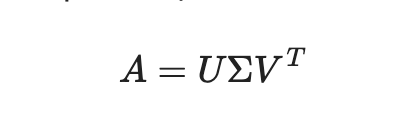

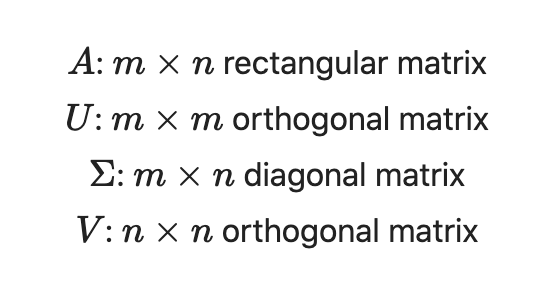

U가 orthognonal matrix라고 한다면, 

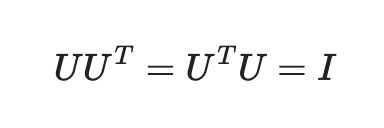

위 성질을 가진다.

Σ가 diagonal matrix라고 한다면 Σ의 대각성분을 제외한 나머지 원소의 값은 모두 0이다.

In [ ]:
def get_svd(s_matrix, k=300):
  u, s, vh = np.linalg.svd(s_matrix.transpose()) # if |s_matrix|=(movie,user), |u|=(user,user), |s|=(user,), |vh|=(movie,movie)
  print(u.shape, s.shape, vh.shape)
  S = s[:k] * np.identity(k, np.float) # |S|=(k,k)
  print(S.shape)
  T = u[:,:k] # |T|=(user,k)
  print(T.shape)
  Dt = vh[:k,:] # |Dt| = (k,movie)
  print(Dt.shape)

  item_factors = np.transpose(np.matmul(S, Dt)) # |item_factors| = (movie,k)
  user_factors = np.transpose(T) # |user_factors| = (k,user)

  return item_factors, user_factors

## 1. with average movie ratings

In [ ]:
item_factors, user_factors = get_svd(sparse_matrix_withmovie)
prediction_result_df = pd.DataFrame(np.matmul(item_factors, user_factors),
                                    columns=sparse_matrix_withmovie.columns.values, index=sparse_matrix_withmovie.index.values) # |prediction_result_df| = (movie, user)

movie_prediction_result_df = prediction_result_df.transpose() # |movie_prediction_result_df| = (user, movie)

(610, 610) (610,) (8938, 8938)
(300, 300)
(610, 300)
(300, 8938)


In [ ]:
print(item_factors.shape)
print(user_factors.shape)

(8938, 300)
(300, 610)


In [ ]:
movie_prediction_result_df.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,34,36,38,39,40,41,42,43,...,184257,184349,184471,184721,184791,184931,184987,184997,185033,185135,185435,185585,187031,187541,187593,187595,187717,188189,188301,188675,188797,189043,189111,189333,189547,190183,190207,190209,190213,190215,190219,191005,193565,193567,193571,193573,193579,193581,193587,193609
1,3.908820,3.390957,4.035030,2.252912,3.053903,3.981066,3.183727,2.744891,2.909088,3.505548,3.706015,2.374035,3.123550,3.933145,2.971819,3.911682,3.793296,3.616735,2.723460,2.714942,3.467551,3.257282,3.125723,3.116005,3.666359,3.445724,3.481224,4.057030,3.950146,3.003699,3.127470,4.045563,3.725531,3.732041,2.000468,3.322564,3.499942,3.799698,3.176480,3.187039,...,3.999934,3.499942,2.498336,3.999934,3.249974,3.999934,2.999950,3.999934,1.999967,4.749644,2.999950,2.750140,3.251965,3.505465,4.126688,3.501081,4.999917,4.499925,3.500506,3.499942,3.999934,2.499959,2.999950,3.999934,0.999983,3.499942,1.499975,3.999934,0.999983,1.499975,0.999983,4.499925,3.499942,2.999950,3.999934,3.999934,3.499942,3.999934,3.499942,3.999934
2,3.911434,3.445683,3.461056,2.240729,2.998555,3.959505,3.151831,2.751379,2.910568,3.406105,3.706765,2.358869,3.126824,3.946110,3.016277,3.840996,3.829437,3.635910,2.722463,2.741404,3.493050,3.267066,3.185609,3.081252,3.647671,3.423465,3.500961,4.075291,3.973008,3.001640,3.126769,3.953079,3.763999,3.739251,2.000506,3.327100,3.499797,3.803588,3.171343,3.168945,...,3.999768,3.499797,2.494128,3.999768,3.255965,3.999768,2.999826,3.999768,1.999884,4.757657,2.999826,2.749987,3.251145,3.489683,4.160032,3.494873,4.999710,4.499739,3.505032,3.499797,3.999768,2.499855,2.999826,3.999768,0.999942,3.499797,1.499913,3.999768,0.999942,1.499913,0.999942,4.499739,3.499797,2.999826,3.999768,3.999768,3.499797,3.999768,3.499797,3.999768
3,3.896327,3.383747,3.439498,2.240612,3.049043,3.935766,3.174809,2.738581,2.910505,3.515399,3.705274,2.346706,3.117167,3.950714,3.000556,3.900426,3.825145,3.602151,2.735374,2.730128,3.429712,3.272879,3.139803,3.148035,3.701209,3.462291,3.481890,4.047783,3.947432,2.993830,0.449036,3.979410,3.709393,3.738304,2.001326,3.303376,3.500003,3.810915,3.161767,3.195110,...,4.000004,3.500003,2.495915,4.000004,3.249723,4.000004,3.000003,4.000004,2.000002,4.749722,3.000003,2.749922,3.254521,3.505089,4.148535,3.498766,5.000005,4.500004,3.499708,3.500003,4.000004,2.500002,3.000003,4.000004,1.000001,3.500003,1.500001,4.000004,1.000001,1.500001,1.000001,4.500004,3.500003,3.000003,4.000004,4.000004,3.500003,4.000004,3.500003,4.000004
4,3.881024,3.421886,3.427186,2.239842,3.057280,3.946683,3.197075,2.748549,2.921073,3.513596,3.709638,2.330166,3.129011,3.946833,2.992122,3.928751,3.817044,3.623509,2.749023,2.709416,2.999745,3.281466,3.146324,3.105717,3.659938,3.462677,3.478352,4.052634,3.926144,2.994820,3.182435,1.983056,3.736292,3.761480,2.001490,3.283147,3.499933,3.795573,3.170177,3.194634,...,3.999923,3.499933,2.500395,3.999923,3.251140,3.999923,2.999942,3.999923,1.999962,4.748841,2.999942,2.749860,3.256529,3.505547,4.145955,3.500337,4.999904,4.499913,3.502930,3.499933,3.999923,2.499952,2.999942,3.999923,0.999981,3.499933,1.499971,3.999923,0.999981,1.499971,0.999981,4.499913,3.499933,2.999942,3.999923,3.999923,3.499933,3.999923,3.499933,3.999923
5,4.018416,3.400912,3.493598,2.184629,3.156865,3.946429,3.246271,2.874286,2.903455,3.256205,3.837746,2.257888,3.091730,3.976458,2.982567,3.866928,3.457249,3.638830,2.668557,2.657656,3.884664,3.295209,3.172401,2.911738,3.736052,3.431177,3.461068,4.039688,3.996906,2.965153,3.146463,4.077958,3.686273,3.870821,2.001778,3.067054,3.500120,3.804698,3.175492,3.171672,...,4.000138,3.500120,2.483630,4.000138,3.249906,4.000138,3.000103,4.000138,2.000069,4.749042,3.000103,2.752446,3.241694,3.502344,4.092567,3.491996,5.000172,4.500155,3.508815,3.500120,4.000138,2.500086,3.000103,4.000138,1.000034,3.500120,1.500052,4.000138,1.000034,1.500052,1.000034,4.500155,3.500120,3.000103,4.000138,4.000138,3.500120,4

## 2. with average user ratings

In [ ]:
item_factors, user_factors = get_svd(sparse_matrix_withuser)
prediction_result_df = pd.DataFrame(np.matmul(item_factors, user_factors),
                                    columns=sparse_matrix_withuser.columns.values, index=sparse_matrix_withuser.index.values) # |prediction_result_df| = (movie, user)

user_prediction_result_df = prediction_result_df.transpose() # |user_prediction_result_df| = (user, movie)

(610, 610) (610,) (8938, 8938)
(300, 300)
(610, 300)
(300, 8938)


In [ ]:
user_prediction_result_df.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,34,36,38,39,40,41,42,43,...,184257,184349,184471,184721,184791,184931,184987,184997,185033,185135,185435,185585,187031,187541,187593,187595,187717,188189,188301,188675,188797,189043,189111,189333,189547,190183,190207,190209,190213,190215,190219,191005,193565,193567,193571,193573,193579,193581,193587,193609
1,4.362666,4.366280,3.966290,4.335373,4.363704,3.983660,4.303573,4.339269,4.305649,4.254211,4.282134,4.272191,4.305426,4.292480,4.367508,4.329744,4.236116,4.315804,4.335157,4.349928,4.390426,4.328058,4.333100,4.285464,4.297623,4.293682,4.293528,4.319689,4.356478,4.329777,4.321528,4.346353,4.321307,4.352456,4.322469,4.311651,4.336900,4.315834,4.319297,4.310632,...,4.320553,4.320659,4.319881,4.320247,4.320783,4.320052,4.320922,4.319682,4.321792,4.319183,4.320103,4.320393,4.321417,4.343645,4.316166,4.320900,4.319551,4.319899,4.319971,4.321276,4.320052,4.319997,4.320593,4.320508,4.338351,4.321614,4.318804,4.321786,4.318208,4.318804,4.318208,4.320182,4.320834,4.321160,4.320508,4.320508,4.320834,4.320508,4.320834,4.321664
2,4.018066,3.941879,3.903070,3.960808,3.907779,3.993262,3.913604,3.941605,3.919774,3.880579,3.943441,3.918753,3.942259,3.949975,3.945655,3.897922,4.026012,3.962097,3.916821,3.927611,3.939632,3.939612,3.967440,3.959351,3.898365,3.929732,3.950717,3.966032,3.944258,3.943119,3.921734,3.899026,3.973978,3.966196,3.939077,3.943800,3.942287,3.925650,3.936770,3.931904,...,3.943699,3.940000,3.937679,3.938932,3.942038,3.940905,3.939593,3.947036,3.938280,3.913061,3.935446,3.946262,3.938680,3.914377,3.948401,3.940092,3.937104,3.938018,3.946582,3.942487,3.940905,3.935944,3.939630,3.941626,3.947114,3.938485,3.928572,3.947002,3.924886,3.928572,3.924886,3.945287,3.937965,3.934304,3.941626,3.941626,3.937965,3.941626,3.937965,3.940416
3,2.503743,2.498854,2.491555,2.529266,2.509395,2.519116,2.486491,2.511599,2.508844,2.517707,2.511558,2.514186,2.516351,2.554171,2.534299,2.479551,2.544206,2.512989,2.491814,2.504471,2.503388,2.517612,2.511993,2.530817,2.516081,2.513982,2.516984,2.517356,2.495134,2.513022,0.383380,2.518260,2.492373,2.525631,2.518249,2.479970,2.513929,2.519828,2.517863,2.516064,...,2.516750,2.516683,2.515888,2.515541,2.516895,2.517157,2.516447,2.515947,2.515737,2.514842,2.517383,2.517969,2.516073,2.522945,2.515949,2.516545,2.513610,2.514575,2.516228,2.516513,2.517157,2.519283,2.516905,2.516569,2.524595,2.517604,2.524039,2.512149,2.526417,2.524039,2.526417,2.516350,2.516789,2.517009,2.516569,2.516569,2.516789,2.516569,2.516789,2.516032
4,3.624253,3.635961,3.619964,3.641844,3.632798,3.643807,3.636671,3.642801,3.615370,3.632327,3.607290,3.649405,3.631232,3.640977,3.642348,3.633410,3.643807,3.632953,3.656087,3.642907,3.010115,3.641869,3.637811,3.641900,3.600203,3.624221,3.629186,3.639269,3.621811,3.632938,3.642877,1.975800,3.649815,3.633827,3.632849,3.597837,3.631389,3.620023,3.636043,3.621379,...,3.632061,3.631896,3.634660,3.631660,3.632287,3.631393,3.632082,3.630840,3.632771,3.632925,3.632303,3.632957,3.632240,3.641846,3.632617,3.632179,3.631302,3.631481,3.630569,3.631749,3.631393,3.631816,3.631864,3.632119,3.642411,3.630964,3.631722,3.631958,3.631674,3.631722,3.631674,3.632685,3.631554,3.630989,3.632119,3.632119,3.631554,3.632119,3.631554,3.632004
5,4.051183,3.581114,3.721059,3.627674,3.519383,3.536805,3.768194,3.682646,3.571370,3.639438,3.758502,3.716790,3.593090,3.739135,3.544159,3.638336,3.573450,3.685931,3.703388,3.602880,3.767780,3.647955,3.633116,3.579576,3.781266,3.683309,3.644241,3.618433,3.674949,3.609795,3.644883,3.645444,3.694475,3.824025,3.630491,2.994323,3.637913,3.638693,3.650969,3.604851,...,3.634138,3.636475,3.619286,3.641151,3.637461,3.638865,3.635243,3.639514,3.631621,3.629838,3.637322,3.631094,3.633085,3.625826,3.694962,3.635317,3.649354,3.645253,3.637108,3.637206,3.638865,3.622887,3.635139,3.636919,3.664728,3.628336,3.598384,3.659643,3.586132,3.598384,3.586132,3.638168,3.635671,3.634422,3.636919,3.636919,3.635671,3

In [ ]:
item_factors.shape

(8938, 300)

#Compare user and movie scenario

In [ ]:
def evaluate(test_df, prediction_result_df):
  groups_with_movie_ids = test_df.groupby(by='movieId')
  groups_with_user_ids = test_df.groupby(by='userId')
  intersection_movie_ids = sorted(list(set(list(prediction_result_df.columns)).intersection(set(list(groups_with_movie_ids.indices.keys())))))
  intersection_user_ids = sorted(list(set(list(prediction_result_df.index)).intersection(set(groups_with_user_ids.indices.keys()))))

  print(len(intersection_movie_ids))
  print(len(intersection_user_ids))

  compressed_prediction_df = prediction_result_df.loc[intersection_user_ids][intersection_movie_ids]

  # test_df에 대해서 RMSE 계산
  grouped = test_df.groupby(by='userId')
  rmse_df = pd.DataFrame(columns=['rmse'])
  for userId, group in tqdm(grouped):
      if userId in intersection_user_ids:
          pred_ratings = compressed_prediction_df.loc[userId][compressed_prediction_df.loc[userId].index.intersection(list(group['movieId'].values))]
          pred_ratings = pred_ratings.to_frame(name='rating').reset_index().rename(columns={'index':'movieId','rating':'pred_rating'})
          actual_ratings = group[['rating', 'movieId']].rename(columns={'rating':'actual_rating'})

          final_df = pd.merge(actual_ratings, pred_ratings, how='inner', on=['movieId'])
          final_df = final_df.round(4) # 반올림
          
          if not final_df.empty:
            rmse = sqrt(mean_squared_error(final_df['actual_rating'], final_df['pred_rating']))
            rmse_df.loc[userId] = rmse

  return final_df, rmse_df

In [ ]:
result_df, _ = evaluate(test_df, user_prediction_result_df)
print(result_df)
print("For user matrix")
print(f"RMSE: {sqrt(mean_squared_error(result_df['actual_rating'].values, result_df['pred_rating'].values))}")

4385
610


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


  0%|          | 0/610 [00:00<?, ?it/s]

     actual_rating  movieId  pred_rating
0              5.0     3527       3.6789
1              3.5    84772       3.6783
2              3.5   103141       3.6758
3              4.0    81132       3.6785
4              4.5   130634       3.6785
..             ...      ...          ...
218            4.0   106100       3.6805
219            4.0   111759       3.6747
220            1.0     4852       3.6787
221            3.0     2628       3.6883
222            5.0     1953       3.6721

[223 rows x 3 columns]
For user matrix
RMSE: 0.8551691150767583


In [ ]:
result_df, _ = evaluate(test_df, movie_prediction_result_df)
print(result_df)
print("For movie matrix")
print(f"RMSE: {sqrt(mean_squared_error(result_df['actual_rating'].values, result_df['pred_rating'].values))}")

4385
610


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


  0%|          | 0/610 [00:00<?, ?it/s]

     actual_rating  movieId  pred_rating
0              5.0     3527       3.6030
1              3.5    84772       3.0433
2              3.5   103141       4.0453
3              4.0    81132       3.5000
4              4.5   130634       3.2496
..             ...      ...          ...
218            4.0   106100       3.8314
219            4.0   111759       3.9239
220            1.0     4852       1.0000
221            3.0     2628       3.1901
222            5.0     1953       3.8234

[223 rows x 3 columns]
For movie matrix
RMSE: 0.8209361471321392


#Experiments on different k

In [ ]:
def find_best_k(sparse_matrix, maximum_k=100):
    print("\nFind best optimized k for Matrix Factorization")
    k_candidates = np.arange(50, maximum_k, 10)
    final_df = pd.DataFrame(columns=['rmse'], index=k_candidates)
    for k in tqdm(k_candidates):
        item_factors, user_factors = get_svd(sparse_matrix, k)
        each_results_df = pd.DataFrame(np.matmul(item_factors, user_factors),
                                    columns=sparse_matrix.columns.values, index=sparse_matrix.index.values)
        each_results_df = each_results_df.transpose()
        
        result_df, _ = evaluate(test_df, each_results_df)
        each_rmse = sqrt(mean_squared_error(result_df['actual_rating'].values, result_df['pred_rating'].values))

        final_df.loc[k]['rmse'] = each_rmse

    return final_df

# Grid search (or coordinate search)

In [ ]:
res = find_best_k(sparse_matrix_withmovie, 200)


Find best optimized k for Matrix Factorization


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


  0%|          | 0/15 [00:00<?, ?it/s]

(610, 610) (610,) (8938, 8938)
(50, 50)
(610, 50)
(50, 8938)
4385
610


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


  0%|          | 0/610 [00:00<?, ?it/s]

(610, 610) (610,) (8938, 8938)
(60, 60)
(610, 60)
(60, 8938)
4385
610


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


  0%|          | 0/610 [00:00<?, ?it/s]

(610, 610) (610,) (8938, 8938)
(70, 70)
(610, 70)
(70, 8938)
4385
610


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


  0%|          | 0/610 [00:00<?, ?it/s]

(610, 610) (610,) (8938, 8938)
(80, 80)
(610, 80)
(80, 8938)
4385
610


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


  0%|          | 0/610 [00:00<?, ?it/s]

(610, 610) (610,) (8938, 8938)
(90, 90)
(610, 90)
(90, 8938)
4385
610


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


  0%|          | 0/610 [00:00<?, ?it/s]

(610, 610) (610,) (8938, 8938)
(100, 100)
(610, 100)
(100, 8938)
4385
610


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


  0%|          | 0/610 [00:00<?, ?it/s]

(610, 610) (610,) (8938, 8938)
(110, 110)
(610, 110)
(110, 8938)
4385
610


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


  0%|          | 0/610 [00:00<?, ?it/s]

(610, 610) (610,) (8938, 8938)
(120, 120)
(610, 120)
(120, 8938)
4385
610


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


  0%|          | 0/610 [00:00<?, ?it/s]

(610, 610) (610,) (8938, 8938)
(130, 130)
(610, 130)
(130, 8938)
4385
610


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


  0%|          | 0/610 [00:00<?, ?it/s]

(610, 610) (610,) (8938, 8938)
(140, 140)
(610, 140)
(140, 8938)
4385
610


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


  0%|          | 0/610 [00:00<?, ?it/s]

(610, 610) (610,) (8938, 8938)
(150, 150)
(610, 150)
(150, 8938)
4385
610


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


  0%|          | 0/610 [00:00<?, ?it/s]

(610, 610) (610,) (8938, 8938)
(160, 160)
(610, 160)
(160, 8938)
4385
610


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


  0%|          | 0/610 [00:00<?, ?it/s]

(610, 610) (610,) (8938, 8938)
(170, 170)
(610, 170)
(170, 8938)
4385
610


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


  0%|          | 0/610 [00:00<?, ?it/s]

(610, 610) (610,) (8938, 8938)
(180, 180)
(610, 180)
(180, 8938)
4385
610


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


  0%|          | 0/610 [00:00<?, ?it/s]

(610, 610) (610,) (8938, 8938)
(190, 190)
(610, 190)
(190, 8938)
4385
610


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


  0%|          | 0/610 [00:00<?, ?it/s]

In [ ]:
res

,rmse
50,0.823432
60,0.826151
70,0.825998
80,0.821733
90,0.823385
100,0.824104
110,0.823003
120,0.82306
130,0.822952
140,0.821839


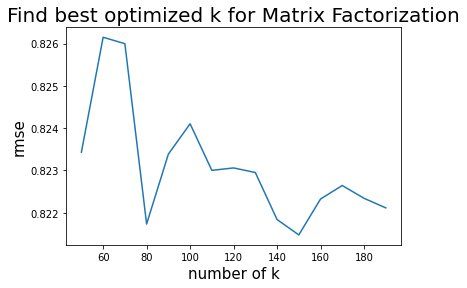

In [ ]:
plt.plot(res.index, res.rmse)
plt.title("Find best optimized k for Matrix Factorization", fontsize=20)
plt.xlabel('number of k', fontsize=15)
plt.ylabel('rmse', fontsize=15)
plt.show()

# Matrix Factorization with Simple Python module

In [ ]:
!pip install matrix-factorization

  Created wheel for matrix-factorization: filename=matrix_factorization-1.3-py3-none-any.whl size=16467 sha256=15f8f7642d99003637d6c4d99153cd62b428ed6b7399f6aaf5dad9041e12d12e
  Stored in directory: /root/.cache/pip/wheels/f6/34/7b/11dd792f060e9c2d7230855147d3bfadbd2b6bbcf5132dcbbc
Successfully built matrix-factorization


In [ ]:
from matrix_factorization import BaselineModel, KernelMF, train_update_test_split

In [ ]:
path = '/content/drive/MyDrive/data/movielens'
ratings_df = pd.read_csv(os.path.join(path, 'ratings.csv'), encoding='utf-8')

print(ratings_df.shape)
print(ratings_df.head())

(100836, 4)
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931


In [ ]:
train_df, test_df = train_test_split(ratings_df, test_size=0.2, random_state=1234)

print(train_df.shape)
print(test_df.shape)

(80668, 4)
(20168, 4)


In [ ]:
train_df.columns

Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')

In [ ]:
new_train_df = train_df
new_train_df = new_train_df.rename(columns={"userId": "user_id", "movieId": "item_id"})
new_train_df.head()

,user_id,item_id,rating,timestamp
95713,600,5943,3.0,1237714356
61560,407,2571,5.0,1424349171
77204,482,8958,4.0,1105397126
93367,599,2322,2.5,1498515283
90892,590,2959,3.5,1258416553


In [ ]:
(
    X_train_initial,
    y_train_initial,
    X_train_update,
    y_train_update,
    X_test_update,
    y_test_update,
) = train_update_test_split(new_train_df, frac_new_users=0.2)

In [ ]:
# 초기  training
matrix_fact = KernelMF(n_epochs=20, n_factors=100, verbose=1, lr=0.001, reg=0.005)
matrix_fact.fit(X_train_initial, y_train_initial)

Epoch  1 / 20  -  train_rmse: 0.9993638135480286
Epoch  2 / 20  -  train_rmse: 0.9733129368645671
Epoch  3 / 20  -  train_rmse: 0.9559576854055991
Epoch  4 / 20  -  train_rmse: 0.942924605105827
Epoch  5 / 20  -  train_rmse: 0.9324896214070323
Epoch  6 / 20  -  train_rmse: 0.9237956936790198
Epoch  7 / 20  -  train_rmse: 0.9162857064147293
Epoch  8 / 20  -  train_rmse: 0.9096589048116452
Epoch  9 / 20  -  train_rmse: 0.9036976744630376
Epoch  10 / 20  -  train_rmse: 0.8982570361609779
Epoch  11 / 20  -  train_rmse: 0.8932401009056656
Epoch  12 / 20  -  train_rmse: 0.8885277640562753
Epoch  13 / 20  -  train_rmse: 0.8840969484122443
Epoch  14 / 20  -  train_rmse: 0.8798913755405952
Epoch  15 / 20  -  train_rmse: 0.8758807661467678
Epoch  16 / 20  -  train_rmse: 0.8720407426771088
Epoch  17 / 20  -  train_rmse: 0.8683389627003326
Epoch  18 / 20  -  train_rmse: 0.8647535113757119
Epoch  19 / 20  -  train_rmse: 0.8612564047433158
Epoch  20 / 20  -  train_rmse: 0.8578627329729582


KernelMF(gamma=0.01, lr=0.001, n_epochs=20, reg=0.005)

In [ ]:
# 추가된 user 데이터로 모델 업데이트
matrix_fact.update_users(
    X_train_update, y_train_update, lr=0.001, n_epochs=20, verbose=1
)

Epoch  1 / 20  -  train_rmse: 0.9251354741700556
Epoch  2 / 20  -  train_rmse: 0.9052061576046082
Epoch  3 / 20  -  train_rmse: 0.8949265871265205
Epoch  4 / 20  -  train_rmse: 0.8883959227365491
Epoch  5 / 20  -  train_rmse: 0.8837245486942642
Epoch  6 / 20  -  train_rmse: 0.8801000440930254
Epoch  7 / 20  -  train_rmse: 0.8771445086694499
Epoch  8 / 20  -  train_rmse: 0.8746197848136
Epoch  9 / 20  -  train_rmse: 0.8723976059815168
Epoch  10 / 20  -  train_rmse: 0.870380694834173
Epoch  11 / 20  -  train_rmse: 0.8685438991697289
Epoch  12 / 20  -  train_rmse: 0.8668332793573635
Epoch  13 / 20  -  train_rmse: 0.865220212712126
Epoch  14 / 20  -  train_rmse: 0.8636928971915534
Epoch  15 / 20  -  train_rmse: 0.8622400970992772
Epoch  16 / 20  -  train_rmse: 0.8608533428388164
Epoch  17 / 20  -  train_rmse: 0.8595212872271811
Epoch  18 / 20  -  train_rmse: 0.8582356804872577
Epoch  19 / 20  -  train_rmse: 0.8569898197491376
Epoch  20 / 20  -  train_rmse: 0.855779184660794


In [ ]:
pred = matrix_fact.predict(X_test_update)
rmse = mean_squared_error(y_test_update, pred, squared=False)
print(f"\nTest RMSE: {rmse:.4f}")


Test RMSE: 0.8848


In [ ]:
# recommendations 가져오기
user = 200
items_known = X_train_initial.query("user_id == @user")["item_id"]
matrix_fact.recommend(user=user, items_known=items_known)

,user_id,item_id,rating_pred
632,200,50,4.447511
142,200,912,4.430150
45,200,858,4.403964
266,200,1089,4.386593
1014,200,2329,4.383066
983,200,750,4.353173
267,200,6016,4.345695
366,200,904,4.344604
109,200,1210,4.342258
129,200,1221,4.337928


## SGD



In [ ]:
baseline_model = BaselineModel(method='sgd', n_epochs = 20, reg = 0.005, lr = 0.01, verbose=1)
baseline_model.fit(X_train_initial, y_train_initial)

pred = baseline_model.predict(X_test_update)
rmse = mean_squared_error(y_test_update, pred, squared = False)

print(f'\nTest RMSE: {rmse:.4f}')

Epoch  1 / 20  -  train_rmse: 0.9114878754880188
Epoch  2 / 20  -  train_rmse: 0.8871379732809493
Epoch  3 / 20  -  train_rmse: 0.8738340858203132
Epoch  4 / 20  -  train_rmse: 0.8640118432851992
Epoch  5 / 20  -  train_rmse: 0.8569217861432942
Epoch  6 / 20  -  train_rmse: 0.8509985954068411
Epoch  7 / 20  -  train_rmse: 0.8464360061075883
Epoch  8 / 20  -  train_rmse: 0.8421716044508951
Epoch  9 / 20  -  train_rmse: 0.8386534077349798
Epoch  10 / 20  -  train_rmse: 0.8353560549309679
Epoch  11 / 20  -  train_rmse: 0.8327975623503204
Epoch  12 / 20  -  train_rmse: 0.8302242601167824
Epoch  13 / 20  -  train_rmse: 0.8277825041475433
Epoch  14 / 20  -  train_rmse: 0.826317805094135
Epoch  15 / 20  -  train_rmse: 0.8238002055642827
Epoch  16 / 20  -  train_rmse: 0.822116330564749
Epoch  17 / 20  -  train_rmse: 0.8204029781877272
Epoch  18 / 20  -  train_rmse: 0.8187825267199759
Epoch  19 / 20  -  train_rmse: 0.81703290471975
Epoch  20 / 20  -  train_rmse: 0.8159428841607635

Test RMSE: 0

In [ ]:
%%time
baseline_model.update_users(X_train_update, y_train_update, n_epochs=20, lr=0.001, verbose=1)
pred = baseline_model.predict(X_test_update)
rmse = mean_squared_error(y_test_update, pred, squared = False)

print(f'\nTest RMSE: {rmse:.4f}')

Epoch  1 / 20  -  train_rmse: 0.8934102245986882
Epoch  2 / 20  -  train_rmse: 0.8734684108186275
Epoch  3 / 20  -  train_rmse: 0.8635088245667732
Epoch  4 / 20  -  train_rmse: 0.8576108744373763
Epoch  5 / 20  -  train_rmse: 0.853610165649222
Epoch  6 / 20  -  train_rmse: 0.850706643288878
Epoch  7 / 20  -  train_rmse: 0.848505300201312
Epoch  8 / 20  -  train_rmse: 0.8467323134012099
Epoch  9 / 20  -  train_rmse: 0.845282412299331
Epoch  10 / 20  -  train_rmse: 0.844060782836166
Epoch  11 / 20  -  train_rmse: 0.8429993320546697
Epoch  12 / 20  -  train_rmse: 0.8420753413970736
Epoch  13 / 20  -  train_rmse: 0.8412585235425333
Epoch  14 / 20  -  train_rmse: 0.8405255080973038
Epoch  15 / 20  -  train_rmse: 0.8398700244612064
Epoch  16 / 20  -  train_rmse: 0.8392713174149748
Epoch  17 / 20  -  train_rmse: 0.8387283237157377
Epoch  18 / 20  -  train_rmse: 0.8382329454081222
Epoch  19 / 20  -  train_rmse: 0.8377766809023132
Epoch  20 / 20  -  train_rmse: 0.8373553551052187

Test RMSE: 0.

# ALS

In [ ]:
baseline_model = BaselineModel(method='als', n_epochs = 20, reg = 0.5, verbose=1)
baseline_model.fit(X_train_initial, y_train_initial)

pred = baseline_model.predict(X_test_update)
rmse = mean_squared_error(y_test_update, pred, squared = False)

print(f'\nTest RMSE: {rmse:.4f}')

Epoch  1 / 20  -  train_rmse: 0.8004800058334578
Epoch  2 / 20  -  train_rmse: 0.7844781493090085
Epoch  3 / 20  -  train_rmse: 0.7830054144230898
Epoch  4 / 20  -  train_rmse: 0.7827683243160889
Epoch  5 / 20  -  train_rmse: 0.7827080788533433
Epoch  6 / 20  -  train_rmse: 0.7826853212409974
Epoch  7 / 20  -  train_rmse: 0.7826726702555423
Epoch  8 / 20  -  train_rmse: 0.782663429010838
Epoch  9 / 20  -  train_rmse: 0.7826557441939799
Epoch  10 / 20  -  train_rmse: 0.7826490300654638
Epoch  11 / 20  -  train_rmse: 0.7826430582709296
Epoch  12 / 20  -  train_rmse: 0.7826377106987804
Epoch  13 / 20  -  train_rmse: 0.7826329084188749
Epoch  14 / 20  -  train_rmse: 0.7826285897161598
Epoch  15 / 20  -  train_rmse: 0.7826247025612317
Epoch  16 / 20  -  train_rmse: 0.7826212016197779
Epoch  17 / 20  -  train_rmse: 0.7826180468162469
Epoch  18 / 20  -  train_rmse: 0.7826152024897336
Epoch  19 / 20  -  train_rmse: 0.7826126368070844
Epoch  20 / 20  -  train_rmse: 0.7826103213061105

Test RMSE